# Driving a Van-Der-Pol oscillator to its steady state

In this example, we're solving a nonlinear model-predictive control problem with direct single shooting.
(This means that the ODE is evaluated for the complete time horizon in one go.)

The Van-der-Pol oscillator has an unstable steady state at the origin and a stable limit cycle for any positive damping factor $\mu$. 
As a system of two first-order ODEs, it is described by

$$
\begin{align*}
\dot{x} &= y \\
\dot{y} &= \mu (1 - x^2) y - x
\end{align*}
$$

Given any starting point arbitrarily close to, but not exactly at the origin, the system will move to its limit cycle: 

![ou](../_static/van_der_pol.png)

We want to keep this system at the origin and introduce a control variable $u$, whose values we want to tweak to accomplish our goal with minimal interventions. 
We're setting up our optimisation problem as

$$
\begin{align*}
\min_{x, \, y, \, u}  &\quad \int_0^T (x^2 + y^2 + c_u \cdot u^2) \, dt \\
\\ s.t. & \\
\dot{x} &= y \\
\dot{y} &= \mu (1 - x^2) y - x + u \\
\\
-1 & \leq u \, \leq 1
\end{align*}
$$

This example is heavily inspired by the CasADi documentation ([here](https://web.casadi.org/docs/#a-simple-test-problem)).
We have modified the problem slightly by ignoring the constraint on the value of $y$ here, and by introducing a weight factor $c_u$ on the controls, which allows us to prioritise deviations from the steady state in the cost. This helps make the problem more robust to initial conditions, at the expense of more heavy-handed control inputs.

We're going to optimise this problem using [Diffrax](https://github.com/patrick-kidger/diffrax) to solve the ODEs, and a set of discrete time points at which the control variable $u$ can change its value. The integral objective is evaluated as a simple left-sided Riemann sum.

First, import everything we need:

In [1]:
import diffrax as dfx
import equinox as eqx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optimistix as optx

Then, we set up the problem:

In [2]:
def van_der_pol(time, states, control):
    x, y = states
    u = control.evaluate(time)
    dydt = (1 - x**2) * y - x + u
    return jnp.array([y, dydt])


class ControlledVanDerPol(eqx.Module):
    t0: float
    t1: float
    dt0: float
    num_control_inputs: int
    control_weight: float

    def interpolate(self, control_inputs):
        """Create a dfx.LinearInterpolation from the control inputs."""
        interval_bounds = jnp.linspace(self.t0, self.t1, self.num_control_inputs + 1)

        # Define offsets for sharp step-wise interpolation
        offsets = jnp.nextafter(interval_bounds[1:-1], interval_bounds[0:-2])
        timepoints = jnp.sort(jnp.concatenate([interval_bounds, offsets]))
        indices = jnp.array([2 * i for i in range(0, self.num_control_inputs)])

        template = jnp.zeros_like(timepoints)
        inputs = jnp.put(template, indices, control_inputs, inplace=False)
        inputs = jnp.put(inputs, indices + 1, control_inputs, inplace=False)

        return dfx.LinearInterpolation(ts=timepoints, ys=inputs)

    def integrate(self, interpolated_control, timepoints, initial_condition):
        """Integrate the system and return the evolving state."""
        saveat = dfx.SaveAt(ts=timepoints)

        return dfx.diffeqsolve(
            dfx.ODETerm(van_der_pol),
            dfx.Tsit5(),
            self.t0,
            self.t1,
            self.dt0,
            initial_condition,
            args=interpolated_control,
            saveat=saveat,
        ).ys

    def __call__(self, control_inputs, timepoints__initial_condition):
        """Compute the objective value for the given control inputs.
        The integral objective function penalises deviations from the origin, as well as
        excessive control inputs. In this example, we approximate the integral with a
        left-sided Riemann sum.

        Returns the evolving state and the interpolated control as auxiliary output.
        """
        timepoints, initial_condition = timepoints__initial_condition
        interpolated_control = self.interpolate(control_inputs)
        states = self.integrate(interpolated_control, timepoints, initial_condition)

        # Compute the cost function as a left-sided Riemann sum
        time_intervals = timepoints[1:] - timepoints[:-1]
        control_values = [
            interpolated_control.evaluate(t) ** 2 for t in timepoints[:-1]
        ]
        control_cost = jnp.sum(jnp.asarray(control_values) * time_intervals)
        weighted_control_cost = self.control_weight * control_cost

        x, y = jnp.asarray(states)[:-1, :].T
        state_cost = jnp.sum(x**2 * time_intervals) + jnp.sum(y**2 * time_intervals)
        objective_value = weighted_control_cost + state_cost

        return objective_value, (states, interpolated_control)

Now, we only need to define some hyperparameters and a starting point and we're good to go!

In [13]:
t0 = 0.0
t1 = 10.0
dt0 = 0.01
num_control_inputs = 30  # Endpoints of intervals
controlled = ControlledVanDerPol(t0, t1, dt0, num_control_inputs, 0.1)
timepoints = jnp.linspace(t0, t1, 100)  # Evaluate the solution at 100 points

u0 = 0.25 * jr.normal(jr.key(0), (num_control_inputs,))  # Random starting point
u0 = jnp.clip(u0, -1, 1)  # Clip initial value to be within bounds
bounds = (-jnp.ones_like(u0), jnp.ones_like(u0))  # Control inputs are bounded
initial_condition = jnp.array([0.1, 0.1])
args = (timepoints, initial_condition)

value, initial_aux = controlled(u0, args)
print("Initial value of the objective function:", value)

Initial value of the objective function: 24.77327


_(Due to using single-shooting without unrolling here, we have actually integrated the constraints on the dynamical system into the computation of the objective function value and no longer have separate constraint functions to specify here.)_

In [14]:
solver = optx.BFGS_B(rtol=1e-10, atol=1e-12)
solution = optx.minimise(controlled, solver, u0, args, bounds=bounds, has_aux=True)

In [15]:
print("Final value of the objective function:", solution.state.f_info.f)

Final value of the objective function: 1.0774604


Let's look at the solution we found:

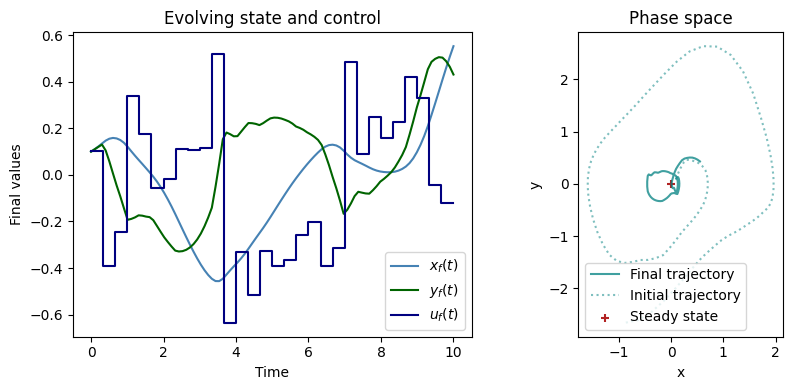

In [21]:
fig, [ax, ax2] = plt.subplots(1, 2, figsize=(9, 4))
initial_state, initial_u = initial_aux
final_state, final_control = solution.aux

# Plot the final states and control values
xf, yf = jnp.asarray(final_state).T
ax.plot(timepoints, xf, label="$x_f(t)$", color="steelblue")
ax.plot(timepoints, yf, label="$y_f(t)$", color="darkgreen")
ax.plot(final_control.ts, final_control.ys, label="$u_f(t)$", color="navy")
# ax.set_ylim(-0.5, 0.5)
ax.set_xlabel("Time")
ax.set_ylabel("Final values")
ax.set_title("Evolving state and control")
ax.legend(loc="lower right")

# Plot in state space
xi, yi = jnp.asarray(initial_state).T
ax2.plot(xf, yf, color="teal", alpha=0.75, label="Final trajectory")
ax2.plot(xi, yi, color="teal", linestyle=":", label="Initial trajectory", alpha=0.5)
ax2.scatter(0, 0, color="firebrick", label="Steady state", marker="+")
ax2.set_aspect("equal")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Phase space")
ax2.legend()

fig.tight_layout()